## Summarizing networks using statistics ##

We need statistical methods to gain an intuitive sense of a network's shape, to detect patterns and test whether these patterns are meaningful.
The most basic descriptive statistics fall largely into three categories:
1. **connectivity measures**, e.g., degree and degree distribution
2. **motif measures**, e.g., triangles count (clustering)
3. **positional measures**, e.g., (shortest) path lenghts

Many of these network measures come in two flavors:
- **node-level** or "local" measures, which we calculate for an individual node $i$
- **network-level** or "global" measures, which we calculate across the entire network

Beware: the network-level statistic is *not always* the average node-level quantity.

### Test networks ###
To test the concepts in this lecture, we will use the following graphs:
- Zachary Karate Club (short: **ZK**):
    - Social network of friendships between 34 members of a karate club at a US university in the 1970s. 
    - See https://www.journals.uchicago.edu/doi/abs/10.1086/jar.33.4.3629752
- Atlas of Economic Complexity export network (short: **EN**)
    - Network of economic products, connected if they are exported at similar rates by the same countries.
    - Edges weights represent a similarity score (called "proximity").
    - Data based on UN Comtrade worldwide trade patterns, Harmonized Commodity Description and Coding System.
    - See https://www.science.org/doi/10.1126/science.1144581

In [3]:
import igraph
import pandas as pd

# ZK is among the "Famous" graphs that igraph makes directly available
ZK = igraph.Graph.Famous('Zachary')
print(ZK.summary())

# EN is available in this HUGE repository of real-world networks: https://networks.skewed.de/
# In the ENHS folder you find the edge list, the node list and a brief description of the graph.
# igraph is a bit "strict" in the data format when reading edge lists, so we pass through a Pandas DataFrame
# in the following line: header=0 skips the first row, names=[...] renames the columns
df = pd.read_csv('EN/edges.csv', header=0, names=['source','target','weight','color'])
# we pass the (source,target,weight) tuples to igraph to construct the graph
EN = igraph.Graph.TupleList(df[['source','target','weight']].itertuples(index=False), edge_attrs="weight")
print(EN.summary())

IGRAPH U--- 34 78 -- 
IGRAPH UNW- 774 1779 -- 
+ attr: name (v), weight (e)


### Degree, strength, density ###

In terms of the adjacency matrix, the **degree** of node $i$ in a simple graph is
$$k_i = \sum_{j} A_{ij} = \sum_{j} A_{ji}$$
If $G$ is weighted, then $k_i$ is called the **strength** of node $i$ (sum of weights of incident edges).

Every edge in an undirected network contributes twice to some degree (once for each endpoint or "stub").
Hence
$$m = \frac{1}{2} \sum_i k_i = \frac{1}{2} \sum_i \sum_j A_{i,j} \qquad \text{and} \qquad \langle k \rangle = \frac{1}{n} \sum_i k_i = \frac{2m}{n}$$

The **density** of a graph is the fraction of the possible edges that do exist, or the ratio of the mean degree over the maximum possible degree:
$$\rho = \frac{m}{\binom{n}{2}} = \frac{2m}{n(n-1)} = \frac{\langle k \rangle}{n-1}$$

### in- and out-degree ###

In a directed network, a node $i$ has three types of degrees: **in-degree** $k^{\mathrm{in}}_i$, **out-degree** 
$k^{\mathrm{out}}_i$, **total degree** $k^{\mathrm{tot}}_i$

$$k^{\mathrm{in}}_i =\sum_j A_{ji} \qquad k^{\mathrm{out}}_i=\sum_j A_{ij} \qquad k^{\mathrm{tot}}_i=k^{\mathrm{in}}_i + k^{\mathrm{out}}_i$$
   
<img src="images/in_out_degree.png" alt="Difference between in- and out-degree" title="Difference between in- and out-degree" style="width: 300px;"/>

The average in-degree equals the average out-degree: ${\langle k^{\mathrm{in}} \rangle}={\langle k^{\mathrm{out}} \rangle}$ (can you prove it?)

In [2]:
import numpy as np

print('the average degree of ZK is:', np.mean(ZK.degree()))
print('the average degree of EN is:', np.mean(EN.degree()))
print('the average strength of EN is:', np.mean(EN.strength(weights='weight')))
print()
print('the density of ZK is:', ZK.density())
print('the density of EN is:', EN.density())

the average degree of ZK is: 4.588235294117647
the average degree of EN is: 4.596899224806202
the average strength of EN is: 30.023711438942943

the density of ZK is: 0.13903743315508021
the density of EN is: 0.0059468295275630035



### Degree distribution ###

If we calculate the degrees of all the vertices in a network $G$, we get $G$'s **degree sequence**.

To measure the variability of node degree across the network, we use the **degree distribution**, denoted
$\Pr(k)$, defined as the probability that a vertex selected uniformly at random in $G$ will have degree $k$.

In [4]:
print('the degree sequence of ZK is:\n')
print(ZK.degree())

print('\nthe degree distribution of ZK can be obtained as follows:\n')
deg_count = {}
for k in ZK.degree():
    if k not in deg_count:
        deg_count[k] = 1
    else:
        deg_count[k] = deg_count[k]+1
deg_dist = {k:v/ZK.vcount() for k,v in deg_count.items()}
print(deg_dist)
print('\nwe counted how many nodes have a given degree and then divided by the total number of nodes')

the degree sequence of ZK is:

[16, 9, 10, 6, 3, 4, 4, 4, 5, 2, 3, 1, 2, 5, 2, 2, 2, 2, 2, 3, 2, 2, 2, 5, 3, 3, 2, 4, 3, 4, 4, 6, 12, 17]

the degree distribution of ZK can be obtained as follows:

{16: 0.029411764705882353, 9: 0.029411764705882353, 10: 0.029411764705882353, 6: 0.058823529411764705, 3: 0.17647058823529413, 4: 0.17647058823529413, 5: 0.08823529411764706, 2: 0.3235294117647059, 1: 0.029411764705882353, 12: 0.029411764705882353, 17: 0.029411764705882353}

we counted how many nodes have a given degree and then divided by the total number of nodes


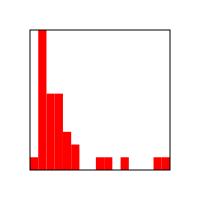

In [5]:
# igraph can extract the degree count for you, as a igraph.statistics.Histogram object
deg_dist_igraph = ZK.degree_distribution()
# this is nice to quickly plot it, not very useful in general
visual_style = {"bbox":(200,200), "margin":30}
igraph.plot(deg_dist_igraph, **visual_style)

In [6]:
# to extract the degree distribution yourself, but faster:
from collections import Counter #counter: data una sequenza di valori me la restituisce in forma di dict
ZK_deg_count = Counter(ZK.degree()) # dict che mi dice quante volte compare ogni grado
ZK_deg_dist = {k:v/ZK.vcount() for k,v in ZK_deg_count.items()} #distribuzione
# or, as a numpy array:
ZK_deg_dist_array = np.array([ZK_deg_count.get(k,0)/ZK.vcount() for k in range(min(ZK.degree()),max(ZK.degree())+1)])

print(ZK_deg_dist)
print()
print(ZK_deg_dist_array) #compaiono 0 dove ho gradi che non compaiono mai

{16: 0.029411764705882353, 9: 0.029411764705882353, 10: 0.029411764705882353, 6: 0.058823529411764705, 3: 0.17647058823529413, 4: 0.17647058823529413, 5: 0.08823529411764706, 2: 0.3235294117647059, 1: 0.029411764705882353, 12: 0.029411764705882353, 17: 0.029411764705882353}

[0.02941176 0.32352941 0.17647059 0.17647059 0.08823529 0.05882353
 0.         0.         0.02941176 0.02941176 0.         0.02941176
 0.         0.         0.         0.02941176 0.02941176]


### Exploring the degree distribution ###

Real-world networks often exhibit a **heavy-tailed** degree distribution:
- the variance $\sigma^2$ of the degree distribution is **large** relative to its mean $\langle k \rangle$
- degrees cannot be negative: large $\sigma^2$ means that $\Pr(k)$ is **right-skewed**
- the **hubs** (high-degree nodes) are often several **orders of magnitude** better connected than the typical node

High variance is difficult to see in a simple distribution plot. You can:
1. use a **log-log** plot, which visually compresses the variance in both $k$ and $\Pr(k)$
2. plot the complementary cumulative distribution function or **CCDF**, defined as $\Pr(K\geq k)$; $K$ is a random variable (the degree of a randomly chosen node); if the minimum degree of a network is $k = 1$, then $\Pr(K\geq1)=1$

this is how EN looks like:


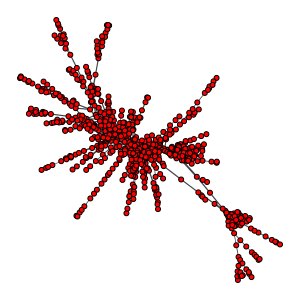

In [7]:
vs_EN = {"bbox":(300,300), "margin":20}
vs_EN['edge_width'] = [w/5 for w in EN.es['weight']]
vs_EN['vertex_size'] = 5
print('this is how EN looks like:')
igraph.plot(EN, **vs_EN)

this is the degree distribution of EN:
it is not easy to see the distribution because of the difference in the counts


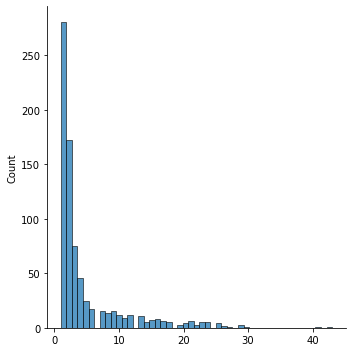

In [9]:
# seaborn is a nice plotting library built on top of the famous matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

print('this is the degree distribution of EN:')
# displot plots distributions from just the list of values
sns.displot(EN.degree())

print('it is not easy to see the distribution because of the difference in the counts')

this are the degree distribution and the CCDF of EN:


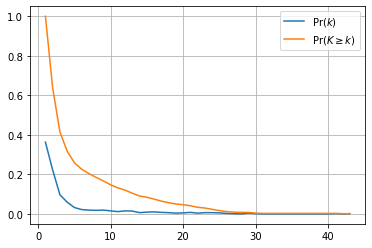

In [10]:
EN_deg_count = Counter(EN.degree())
EN_deg_dist_array = np.array([EN_deg_count.get(k,0)/EN.vcount() for k in range(min(EN.degree()),max(EN.degree())+1)])
# the CCDF is the "backward" cumulative sum of the degree distribution
EN_CCDF = EN_deg_dist_array[::-1].cumsum()[::-1]
degree_range = range(1,len(EN_deg_dist_array)+1)

print('this are the degree distribution and the CCDF of EN:')
plt.plot(degree_range,EN_deg_dist_array, label='$\Pr(k)$')
plt.plot(degree_range,EN_CCDF, label='$\Pr(K\geq k)$')
plt.legend()
plt.grid()
# ccdf mi dice per ogni k quale è la probabilità di avere grado maggiore di k 

this are the same plots, but in log-log scale:

what do they look like?


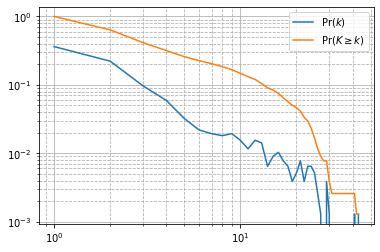

In [11]:
print('this are the same plots, but in log-log scale:')
plt.loglog(degree_range,EN_deg_dist_array, label='$\Pr(k)$')
plt.loglog(degree_range,EN_CCDF, label='$\Pr(K\geq k)$')
plt.legend()
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle='--')

print()
print('what do they look like?')
# 90 percento della rete (tra 1 e 0,1 ho il 90 percento della rete) ha grado sotto a 15 
# l' 1% (tutto quello che sta sotto 0,01) ha grado sopra a 30

### Exploring the degree distribution ###

The loglog plot above **stretches out** the **low-degree** structure while **compressing** the range of the **high-degree** portion of the distribution.
- in the degree distribution, the tail is still *noisy* (rare events are difficult to see!)
- the CCDF is smoother: we clearly see the bend at around $k = 20$, and we clearly see patterns:
    - 90% of nodes have degree $k\leq 15$ (approx.)
    - only 1% of nodes have degree $k>30$ (approx.)

Remark: 1% of the network is $\approx 8$ nodes; if these 8 nodes all have degree $>30$, altogether they "touch" at least $8\cdot 30 = 240$ edges, that is, $\approx 14\%$ of all edges. In other words, approximately 1 in 7 edges leads to one of these 8 nodes.
The networks is highly **centralized**

In [12]:
# l'1% della rete è raggiungibilie dal 14% degli archi. Ovvero prendendo un arco a caso ho la probabilità di 1 u 7 di finire in uno di questi nodi 

### Exploring the degree distribution ###

The structure of **real networks** varies enormously, even in something as *simple* as the degree distribution.
However, there is a commonality across **real degree distributions**: their often **enormously high variance**.

This is the CCDF of 100 networks drawn from biological, social, information, and technological networks:

<img src="images/CCDF_comparison.png" alt="Comparison of the CCDF for 100 real networks" title="Comparison of the CCDF for 100 real networks" style="width: 400px;"/>